# Comparing all samplers

This results depends on [Benchpress](https://github.com/felixleopoldo/benchpress) output

Please change the variable BENCHPRESS_LOC to the location of benchpress results, normally in `benchpress/results/`


## Parameter setup

In [4]:
## general setup
BENCHPRESS_LOC = '/home/mo/src/decomposable_paper/benchpress/results/'
SAVE_LOC = '/home/mo/src/decomposable_paper/benchpress/img/'
SAVE_PLOTS = True
## model constants
graph_model = 'cta'#'cta'  # either cta or bandmat


In [5]:
## Default constants
model_name = {'cta': 'CTA', 'bandmat': 'AR'}
model_fullname = {
    'cta': 'Christmas Tree Algorithm',
    'bandmat': 'Auto-regressive',
}



In [6]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('..')
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
import parallelDG.auxiliary_functions as aux
from parallelDG import mh_greenthomas
from parallelDG import mh_parallel
import parallelDG.distributions.g_intra_class as gic
import parallelDG.graph.decomposable as dlib
from networkx.drawing.nx_pydot import graphviz_layout
sns.set_style("whitegrid")

In [7]:
import tarfile
import pandas as pd
from io import StringIO

def read_csv_from_tar_gz(tar_gz_path, csv_file_name=None):
    """
    Reads a CSV file from a tar.gz archive into a pandas DataFrame.
    
    Parameters:
    - tar_gz_path: str, the path to the tar.gz archive.
    - csv_file_name: str, optional, the name of the CSV file to extract. 
                     If not provided, the first CSV file found will be read.
    
    Returns:
    - A pandas DataFrame containing the data from the CSV file.
    """
    if 'csv' in tar_gz_path: 
        return pd.read_csv(tar_gz_path)
    with tarfile.open(tar_gz_path, "r:gz") as tar:
        # If a specific CSV file name is provided, use it; otherwise, find the first CSV file
        if csv_file_name:
            try:
                csv_member = tar.getmember(csv_file_name)
            except KeyError:
                raise FileNotFoundError(f"The specified CSV file {csv_file_name} was not found in the archive.")
        else:
            # Assume there's only one CSV file and extract it
            csv_member = next((m for m in tar.getmembers() if m.name.endswith('.csv')), None)
            if csv_member is None:
                raise FileNotFoundError("No CSV file found in the tar.gz archive.")
        
        # Extract the CSV file content
        f = tar.extractfile(csv_member)
        if f is not None:
            content = f.read()
            # Convert bytes to a string if necessary
            if isinstance(content, bytes):
                content = content.decode('utf-8')
            # Use StringIO to convert the string to a file-like object and read it into a pandas DataFrame
            df = pd.read_csv(StringIO(content))
            return df
        else:
            raise Exception("Could not extract the CSV file from the tar.gz archive.")

# Example usage:
# df = read_csv_from_tar_gz('/path/to/your/archive.tar.gz')
# print(df.head())


In [8]:
def list_with_pattern(pat, ls):
    return [l for l in ls if pat in l]

def algo_files(location, algo_name = 'parallel', pattern=None): 
    filelist = []
    for root, dir, files in os.walk(BENCHPRESS_LOC): 
        for file in files: 
            filelist.append(os.path.join(root,file))
    
    alg = algo_name
    fl = list_with_pattern(alg, filelist)
    if pattern: 
        if type(pattern) is list: 
            final_ls = fl
            for p in pattern: 
                final_ls = list_with_pattern(p, final_ls)
            return sorted(final_ls)
        else:
            return sorted(list_with_pattern(pattern, fl))
    else: 
        return sorted(fl)
    

def edges_str_to_list(str, edgesymb="-"):
    edges_str = str[1:-1].split(";")
    edges = [(edge.split(edgesymb)[0], edge.split(edgesymb)[1])
             for edge in edges_str if len(edge.split(edgesymb)) == 2]
    return edges

def size_traj(filename):
    edgesymb = "-"
    g = nx.Graph()
    size = []
    df = read_csv_from_tar_gz(filename)
    if 'subindex' in df.columns: 
        df.rename(columns={'added_sub': 'added', 
                           'subindex': 'index', 
                          'removed_sub': 'removed'}
                  , inplace=True)
    
    for index, row in df.iterrows():
            added = edges_str_to_list(row["added"], edgesymb)
            removed = edges_str_to_list(row["removed"], edgesymb)
            g.add_edges_from(added)
            g.remove_edges_from(removed)
            size.append(g.size())
    df["size"] = size
    T = df["index"].iloc[-1]  # approximate length
    newindex = pd.Series(range(T))
    # removes the two first rows.
    df2 = df[["index", "size"]][2:].set_index("index")
    df2 = df2.reindex(newindex).reset_index().reindex(
        columns=df2.columns).fillna(method="ffill")
    return df2

def num_samples(filename):
    df = read_csv_from_tar_gz(filename)
    if 'subindex' in df.columns:
        a = df['subindex'].iloc[-1]
        print(f"num samples {a}")
    else:
        a = df['index'].iloc[-1]
        print(f"num samples {a}")
    return a


def size_traj_plot(filename): 
    df = size_traj(filename)
    df["size"].plot()
    plt.tight_layout()
    plt.xlabel('Sample number')
    plt.ylabel('Number of graph edges')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    return df
    #plt.savefig(snakemake.output["plot"])


def score_traj_plot(filename): 
    edgesymb = "-"
    g = nx.Graph()
    df = read_csv_from_tar_gz(filename)
    T = df["index"].iloc[-1]  # approximate length

    newindex = pd.Series(range(T))
      # removes the two first rows.
    df2 = df[["index", "score"]][2:].set_index("index")
    df2 = df2.reindex(newindex).reset_index().reindex(
        columns=df2.columns).fillna(method="ffill")
    df2["score"].plot()
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.ylabel('Log-likelihood')
    plt.xlabel('Sample number')
    plt.tight_layout()
    return df2
    #plt.savefig(snakemake.output["plot"])
    
    
def autocorrelation(traj, lag):
    return aux.autocorrelation_plot(traj,lag = lag,
                                 return_series=True)

def acceptance_ratio(traj):
    dx = (np.diff(traj)!=0) * 1.0
    ar = np.mean(dx, dtype=float)
    par = np.cumsum(dx, dtype=float)/(np.array(range(len(dx))) + 1.0)
    print('Acceptance ratio {:2f}'.format(ar))
    return ar, par

def heatmap_df(filename, burnin_frac=0.5):
    edgesymb = "-"
    g = nx.Graph()
    df = read_csv_from_tar_gz(filename)
    nodeorder = []
    tmpedges = edges_str_to_list(df["added"][0], edgesymb)
    nodeorder.append(tmpedges[0][0])
    for edge in tmpedges:
        nodeorder.append(edge[1])
            
    full_its = df["index"].iloc[-1]        
    totalits = int(full_its * (1.0 - burnin_frac))
    burnin_ind = int(full_its * burnin_frac)
    
    for index, row in df.iterrows():
        
        if row["index"] == 0:
            if burnin_ind == 0:
                heatmap = nx.to_numpy_array(g) #this is strange
            else:
                # Just to init the matrix with the right dimensions  
                heatmap = nx.to_numpy_array(g) * 0 

        if row["index"] > burnin_ind:
            cur_index = df["index"].iloc[index]
            prev_index = df["index"].iloc[index-1]
                
            weight = cur_index - prev_index            

            heatmap += nx.to_numpy_array(g, nodelist=nodeorder) * weight

        added = edges_str_to_list(row["added"], edgesymb)
        removed = edges_str_to_list(row["removed"], edgesymb)
        g.add_edges_from(added)
        g.remove_edges_from(removed)

   
    heatmap /= totalits                             
    heatmap_df = pd.DataFrame(heatmap)
    heatmap_df.columns = g.nodes()
    return heatmap_df

def plot_heatmap(filename, cbar=True, annot=False, xticklabels=10, yticklabels=10):
    heatmap = heatmap_df(filename, 0.5)
    plot_graph(heatmap, cbar, annot, xticklabels, yticklabels)
    

def plot_nx_graph(heatmap):
    sns.set_style("whitegrid")
    options = {
        "font_size": 8,
        "node_size": 100,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 1,
        "width": 1,
    }
    heatmap.index = heatmap.columns
    ar_graph = nx.from_pandas_adjacency(heatmap)
    pos = graphviz_layout(ar_graph, prog="fdp")
    nx.draw_networkx(ar_graph,pos=pos, with_labels=False, **options)

    # Set margins for the axes so that nodes aren't clipped
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    

def most_samped_graph(filename):
    edgesymb = "-"
    g = nx.Graph()
    df = read_csv_from_tar_gz(filename)
    most_sampled = aux.most_sampled_graph(traj.trajectory[burnin:])
    most_sampled
    aux.plot_heatmap(nx.to_numpy_array(most_sampled['g']), xticklabels=10, yticklabels=10)
    
def plot_graph(heatmap, cbar=True, annot=False, xticklabels=10, yticklabels=10):
    heatmap.index = heatmap.columns
    mask = np.zeros_like(heatmap)
    mask[np.triu_indices_from(mask)] = True

    
    with sns.axes_style("white"):
        ax = sns.heatmap(heatmap, mask=mask, annot=annot,
                         cmap="Blues",
                         vmin=0.0, vmax=1.0, square=True,
                         cbar=cbar,linewidth=1,
                         xticklabels=xticklabels,
                         yticklabels=yticklabels)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

        
    #sns.set_style("whitegrid")
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=12)
    plt.tight_layout()


def custom_roc_curve(true_labels, scores, thresholds):
    tpr_list = []
    fpr_list = []

    # Calculate TPR and FPR for each threshold
    for threshold in thresholds:
        TP = FP = TN = FN = 0
        for score, label in zip(scores, true_labels):
            if score >= threshold:
                if label == 1:
                    TP += 1
                else:
                    FP += 1
            else:
                if label == 1:
                    FN += 1
                else:
                    TN += 1

        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) != 0 else 0

        tpr_list.append(TPR)
        fpr_list.append(FPR)

    return fpr_list, tpr_list
    

def fpr_tpr(filename_true_graph, filename_traj):
    thresholds = np.arange(0, 1.1, 0.1)  # From 0 to 1 with 0.1 increment
    adjacency_matrix = read_csv_from_tar_gz(filename_true_graph)
    heatmap = heatmap_df(filename_traj, 0.5).to_numpy().flatten()
    # Flatten the matrices to create a 1D array
    scores = heatmap.flatten() # These are your predicted scores/probabilities
    true_labels = adjacency_matrix.to_numpy().flatten() # These are your true binary labels

    # Calculate ROC metrics
    fpr, tpr = custom_roc_curve(true_labels, scores, thresholds)
    return np.array(fpr), np.array(tpr), thresholds

def fpr_tpr_files(list_traj, list_true_graphs):
    k =  len(list_traj)
    fpr = tpr = thresholds = 0.0
    for traj, true_graph in zip(list_traj, list_true_graphs):
        fpr1, tpr1, thresholds = fpr_tpr(true_graph, traj)
        fpr += fpr1 / k
        tpr += tpr1 /k
    
    return fpr, tpr, thresholds
    

    
def create_filename(filename, loc = SAVE_LOC):
    return loc + filename + '_' + graph_model

    
def save_location(filename, loc = SAVE_LOC):
    if SAVE_PLOTS:
        f = create_filename(filename, loc) + '.jpg'
        print(f"save to: {f}")
        plt.savefig(f, dpi = 600, bbox_inches='tight')
        plt.clf()
    else: 
        plt.show()

In [9]:
## Extrat location of datafile
paralleldg_files = algo_files(BENCHPRESS_LOC, 'parallel', ['parallel=True', graph_model, 'tar.gz'])
paralleldg_files = [f for f in paralleldg_files if 'subindex' not in f]
paralleldg_files_sub = algo_files(BENCHPRESS_LOC, 'parallel', ['subindex.csv', 'parallel=True', graph_model])
gt13_files = algo_files(BENCHPRESS_LOC, 'athomas', ['sampler=2', graph_model, 'tar.gz', 'full_output=False'])
gt13_files = [f for f in gt13_files if 'subindex' not in f]


paralleldg_files_single_move = algo_files(BENCHPRESS_LOC, 'parallel', ['parallel=False', graph_model, 'tar.gz'])
gt13_single_move_files = algo_files(BENCHPRESS_LOC, 'athomas', ['sampler=1', graph_model, 'tar.gz', 'full_output=False'])
gt13_single_move_files = [f for f in gt13_single_move_files if 'subindex' not in f]

gg99_files = algo_files(BENCHPRESS_LOC, 'athomas', ['sampler=0', graph_model, 'tar.gz', 'full_output=False'])
gg99_files = [f for f in gg99_files if 'subindex' not in f]

true_graph_files = algo_files(BENCHPRESS_LOC, 'adjmat/',[graph_model, '.csv'])

trilearn_files = algo_files(BENCHPRESS_LOC, 'pgibbs', [graph_model, 'adjvecs/adjmat', 'M=1000'])

In [10]:
print(f"Number of files (should be equal)  \n \
     Parallel \t\t\t\t{len(paralleldg_files)} \n \
     Single-move \t\t\t{len(paralleldg_files_single_move)} \n \
     \n \
     Green & Thomas (2013) - multi-edge \t{len(gt13_files)} \n \
     Green & Thomas (2013) - single-edge \t{len(gt13_single_move_files)} \n \
     \n \
     Guidici & Green (1999) \t\t{len(gg99_files)} \n \
     \n \
     Trilearn \t \t \t\t{len(trilearn_files)} \n \
     True graph files \t \t \t{len(true_graph_files)}")

Number of files (should be equal)  
      Parallel 				10 
      Single-move 			10 
      
      Green & Thomas (2013) - multi-edge 	10 
      Green & Thomas (2013) - single-edge 	10 
      
      Guidici & Green (1999) 		10 
      
      Trilearn 	 	 		10 
      True graph files 	 	 	10


In [11]:
## titles 
gt13 = 'GT13-m' + ' - ' + model_name[graph_model]
gt13_single = 'GT13-s' + ' - ' + model_name[graph_model]
gg99 = 'GG99' + ' - ' + model_name[graph_model]
parallel = 'Parallel sampler' + ' - ' + model_name[graph_model]
single_move = 'Single-move sampler' + ' - ' + model_name[graph_model]
trilearn = 'O19 - Gibbs sampler' + ' - ' + model_name[graph_model]

# Trace plots of likliehood

In [244]:
for f in gt13_files:
    score_traj_plot(f)
plt.ylim((0, 2400))
plt.title(gt13)
save_location('gt_loglikelihood_10_traj')

save to: /home/mo/src/decomposable_paper/benchpress/img/gt_loglikelihood_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [245]:
for f in gt13_single_move_files:
    score_traj_plot(f)
plt.ylim((0, 2400))
plt.title(gt13_single)
save_location('gt_single_loglikelihood_10_traj')

save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_loglikelihood_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [246]:
for f in gg99_files:
    score_traj_plot(f)
plt.ylim((0, 2400))
plt.title(gg99)
save_location('gg_loglikelihood_10_traj')

save to: /home/mo/src/decomposable_paper/benchpress/img/gg_loglikelihood_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [247]:
for f in paralleldg_files:
    score_traj_plot(f)
plt.ylim((0,2400))
plt.title(parallel)
save_location('parallel_loglikelihood_10_traj')

save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_loglikelihood_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [248]:
for f in paralleldg_files_single_move:
    score_traj_plot(f)
plt.ylim((0,2400))
plt.title(single_move)
save_location('single_move_loglikelihood_10_traj')

save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_loglikelihood_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [249]:
for f in trilearn_files:
    score_traj_plot(f)
plt.ylim((0,2400))
plt.title(trilearn)
save_location('trilearn_loglikelihood_10_traj')

save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_loglikelihood_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

# Trace plot of number of edges

In [250]:
for f in gt13_files:
    size_traj_plot(f)
plt.title(gt13)
save_location('gt_size_traceplot_10_traj')

save to: /home/mo/src/decomposable_paper/benchpress/img/gt_size_traceplot_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [251]:
for f in gt13_single_move_files:
    size_traj_plot(f)
plt.title(gt13_single)
save_location('gt_single_size_traceplot_10_traj')

save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_size_traceplot_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [252]:
for f in gg99_files:
    size_traj_plot(f)
plt.title(gg99)
save_location('gg_size_traceplot_10_traj')

save to: /home/mo/src/decomposable_paper/benchpress/img/gg_size_traceplot_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [253]:
for f in paralleldg_files:
    size_traj_plot(f)
plt.title(parallel)
save_location('parallel_size_traceplot_10_traj')

save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_size_traceplot_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [254]:
for f in paralleldg_files_single_move:
    size_traj_plot(f)
plt.title(single_move)
save_location('single_move_size_traceplot_10_traj')

save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_size_traceplot_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [255]:
for f in trilearn_files:
    size_traj_plot(f)
plt.title(trilearn)
save_location('trilearn_size_traceplot_10_traj')

save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_size_traceplot_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

# Acceptance ratio

In [256]:
acc_ratio_list =[]
for f in paralleldg_files:
    a, par = acceptance_ratio(size_traj(f)['size'])
    acc_ratio_list.append(a)


Acceptance ratio 0.376116
Acceptance ratio 0.419335
Acceptance ratio 0.374893
Acceptance ratio 0.360523
Acceptance ratio 0.316748
Acceptance ratio 0.361448
Acceptance ratio 0.381200
Acceptance ratio 0.392744
Acceptance ratio 0.391274
Acceptance ratio 0.371332


In [257]:
acc_ratio_list_single =[]
for f in paralleldg_files_single_move:
    a, par = acceptance_ratio(size_traj(f)['size'])
    acc_ratio_list_single.append(a)

Acceptance ratio 0.191895
Acceptance ratio 0.218001
Acceptance ratio 0.158747
Acceptance ratio 0.138647
Acceptance ratio 0.157413
Acceptance ratio 0.137685
Acceptance ratio 0.160575
Acceptance ratio 0.171145
Acceptance ratio 0.168342
Acceptance ratio 0.163463


In [258]:
acc_ratio_list_sub =[]
for f in paralleldg_files_sub:
    a, par = acceptance_ratio(size_traj(f)['size'])
    acc_ratio_list_sub.append(a)


Acceptance ratio 0.203403
Acceptance ratio 0.219566
Acceptance ratio 0.202111
Acceptance ratio 0.174284
Acceptance ratio 0.153625
Acceptance ratio 0.179538
Acceptance ratio 0.183844
Acceptance ratio 0.184300
Acceptance ratio 0.192405
Acceptance ratio 0.179090


In [259]:
acc_ratio_list_gt =[]
for f in gt13_files:
    a, par = acceptance_ratio(size_traj(f)['size'])
    acc_ratio_list_gt.append(a)


Acceptance ratio 0.066522
Acceptance ratio 0.071196
Acceptance ratio 0.062812
Acceptance ratio 0.059361
Acceptance ratio 0.054055
Acceptance ratio 0.059993
Acceptance ratio 0.056812
Acceptance ratio 0.063403
Acceptance ratio 0.065234
Acceptance ratio 0.056379


In [260]:
acc_ratio_list_gt_single =[]
for f in gt13_single_move_files:
    a, par = acceptance_ratio(size_traj(f)['size'])
    acc_ratio_list_gt_single.append(a)


Acceptance ratio 0.184598
Acceptance ratio 0.181148
Acceptance ratio 0.181507
Acceptance ratio 0.176482
Acceptance ratio 0.159808
Acceptance ratio 0.175082
Acceptance ratio 0.169651
Acceptance ratio 0.176042
Acceptance ratio 0.165133
Acceptance ratio 0.154552


In [261]:
acc_ratio_list_gg =[]
for f in gg99_files:
    a, par = acceptance_ratio(size_traj(f)['size'])
    acc_ratio_list_gg.append(a)


Acceptance ratio 0.073754
Acceptance ratio 0.080554
Acceptance ratio 0.069165
Acceptance ratio 0.061131
Acceptance ratio 0.049963
Acceptance ratio 0.070336
Acceptance ratio 0.078990
Acceptance ratio 0.086153
Acceptance ratio 0.098450
Acceptance ratio 0.065261


In [262]:
acc_ratio_list_trilean =[]
for f in trilearn_files:
    a, par = acceptance_ratio(size_traj(f)['size'])
    acc_ratio_list_trilean.append(a)

Acceptance ratio 0.065718
Acceptance ratio 0.096238
Acceptance ratio 0.093856
Acceptance ratio 0.072380
Acceptance ratio 0.103856
Acceptance ratio 0.090754
Acceptance ratio 0.079956
Acceptance ratio 0.065992
Acceptance ratio 0.075005
Acceptance ratio 0.073337


Text(0, 0.5, 'Acceptance rate (%), over graph-updates.')

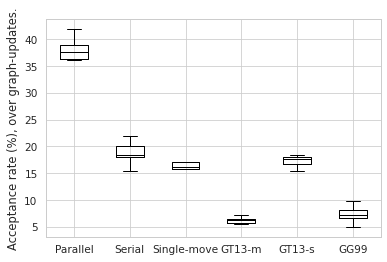

In [263]:
df = pd.DataFrame({'Parallel' : np.array(acc_ratio_list) * 100.0, 
                  'Serial': np.array(acc_ratio_list_sub) * 100.0,
                  'Single-move': np.array(acc_ratio_list_single) * 100.0,
                   'GT13-m': np.array(acc_ratio_list_gt) * 100.0, 
                   'GT13-s': np.array(acc_ratio_list_gt_single) * 100.0,
                   'GG99': np.array(acc_ratio_list_gg) * 100.0})

df.to_csv(create_filename('gt_parallel_acceptance_rate_10_traj' + '.csv'))

ax = df.plot(kind='box',
             color=dict(boxes='black', whiskers='black', medians='black', caps='black'),
             #boxprops=dict(linestyle='-', linewidth=.5),
             #flierprops=dict(linestyle='-', linewidth=.5),
             #medianprops=dict(linestyle='-', linewidth=.5),
             #whiskerprops=dict(linestyle='-', linewidth=.5),
             #capprops=dict(linestyle='-', linewidth=.5),
             showfliers=False, grid=True, rot=0)

ax.set_ylabel('Acceptance rate (%), over graph-updates.')
#save_location('gt_parallel_acceptance_rate_10_traj')



# Autocorrelation

In [264]:
## parallel sampler
burnin = 300000
lag = 20000
data = dict()
for f in paralleldg_files:
    size = size_traj(f)
    burned = size['size'].values[-burnin:]
    data[f] = autocorrelation(burned, lag)
x = np.arange(lag) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
for f in paralleldg_files:
    y = data[f]
    ax.plot(x, y)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title(parallel)
plt.ylim((-0.4, 1))
plt.xlim((0,20000))
save_location('parallel_autocorrelation_10_traj')

/home/mo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # Remove the CWD from sys.path while we load stuff.


save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_autocorrelation_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [265]:
## single move sampler
burnin = 300000
lag = 20000
data = dict()
for f in paralleldg_files_single_move:
    size = size_traj(f)
    burned = size['size'].values[-burnin:]
    data[f] = autocorrelation(burned, lag)
x = np.arange(lag) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number oweatf graph edges")
for f in paralleldg_files_single_move:
    y = data[f]
    ax.plot(x, y)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title(single_move)
plt.ylim((-0.4, 1))
plt.xlim((0,20000))
save_location('single_move_autocorrelation_10_traj')

/home/mo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # Remove the CWD from sys.path while we load stuff.


save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_autocorrelation_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [266]:
# GT 13 -- multi-edge
burnin = 500000
lag = 150000
data = dict()
for f in gt13_files:
    size = size_traj(f)
    burned = size['size'].values[-burnin:]
    data[f] = autocorrelation(burned, lag)
x = np.arange(lag) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
for f in gt13_files:
    y = data[f]
    ax.plot(x, y, linewidth=1)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title(gt13)
plt.ylim((-0.4, 1))
save_location('gt_autocorrelation_10_traj')

/home/mo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # Remove the CWD from sys.path while we load stuff.


save to: /home/mo/src/decomposable_paper/benchpress/img/gt_autocorrelation_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [267]:
# GT 13 -- single-edge
burnin = 500000
lag = 150000
data = dict()
for f in gt13_single_move_files:
    size = size_traj(f)
    burned = size['size'].values[-burnin:]
    data[f] = autocorrelation(burned, lag)
x = np.arange(lag) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
for f in gt13_single_move_files:
    y = data[f]
    ax.plot(x, y, linewidth=1)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title(gt13_single)
plt.ylim((-0.4, 1))
save_location('gt_single_autocorrelation_10_traj')

/home/mo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # Remove the CWD from sys.path while we load stuff.


save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_autocorrelation_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [268]:
# GF 99
burnin = 500000
lag = 150000
data = dict()
for f in gg99_files:
    size = size_traj(f)
    burned = size['size'].values[-burnin:]
    data[f] = autocorrelation(burned, lag)
x = np.arange(lag) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
for f in gg99_files:
    y = data[f]
    ax.plot(x, y, linewidth=1)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title(gg99)
plt.ylim((-0.4, 1))
save_location('gg_autocorrelation_10_traj')

/home/mo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # Remove the CWD from sys.path while we load stuff.


save to: /home/mo/src/decomposable_paper/benchpress/img/gg_autocorrelation_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

In [269]:
# trilearn
burnin = 1000
lag = 1000
data = dict()
for f in trilearn_files:
    size = size_traj(f)
    burned = size['size'].values[-burnin:]
    data[f] = autocorrelation(burned, lag)
x = np.arange(lag) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
for f in trilearn_files:
    y = data[f]
    ax.plot(x, y, linewidth=1)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title(trilearn)
plt.ylim((-0.5, 1))
save_location('trilearn_autocorrelation_10_traj')

/home/mo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # Remove the CWD from sys.path while we load stuff.


save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_autocorrelation_10_traj_cta.jpg


<Figure size 432x288 with 0 Axes>

# Heatmap

In [270]:
k=0
for f in gt13_files:
    plot_heatmap(f, cbar=False)
    plt.title(gt13 + f" Graph {k+1}")
    save_location('gt_heatmap_traj_' + str(k))
    k+=1

save to: /home/mo/src/decomposable_paper/benchpress/img/gt_heatmap_traj_0_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_heatmap_traj_1_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_heatmap_traj_2_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_heatmap_traj_3_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_heatmap_traj_4_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_heatmap_traj_5_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_heatmap_traj_6_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_heatmap_traj_7_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_heatmap_traj_8_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_heatmap_traj_9_cta.jpg


<Figure size 432x288 with 0 Axes>

In [271]:
k=0
for f in gg99_files:
    plot_heatmap(f, cbar=False)
    plt.title(gg99 + f" Graph {k+1}")
    save_location('gg_heatmap_traj_' + str(k))
    k+=1

save to: /home/mo/src/decomposable_paper/benchpress/img/gg_heatmap_traj_0_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gg_heatmap_traj_1_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gg_heatmap_traj_2_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gg_heatmap_traj_3_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gg_heatmap_traj_4_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gg_heatmap_traj_5_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gg_heatmap_traj_6_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gg_heatmap_traj_7_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gg_heatmap_traj_8_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gg_heatmap_traj_9_cta.jpg


<Figure size 432x288 with 0 Axes>

In [272]:
k=0
for f in gt13_single_move_files:
    plot_heatmap(f, cbar=False)
    plt.title(gt13_single + f" Graph {k+1}")
    save_location('gt_single_heatmap_traj_' + str(k))
    plt.clf()
    k+=1

save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_heatmap_traj_0_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_heatmap_traj_1_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_heatmap_traj_2_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_heatmap_traj_3_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_heatmap_traj_4_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_heatmap_traj_5_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_heatmap_traj_6_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_heatmap_traj_7_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_heatmap_traj_8_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/gt_single_heatmap_traj_9_cta.jpg


<Figure size 432x288 with 0 Axes>

In [273]:
k=0
for f in paralleldg_files:
    plot_heatmap(f, cbar=False)
    plt.title(parallel + f" Graph {k+1}")
    save_location('parallel_heatmap_traj_' + str(k))
    plt.clf()
    k+=1

save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_heatmap_traj_0_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_heatmap_traj_1_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_heatmap_traj_2_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_heatmap_traj_3_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_heatmap_traj_4_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_heatmap_traj_5_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_heatmap_traj_6_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_heatmap_traj_7_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_heatmap_traj_8_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/parallel_heatmap_traj_9_cta.jpg


<Figure size 432x288 with 0 Axes>

In [274]:
k=0
for f in paralleldg_files_single_move:
    plot_heatmap(f, cbar=False)
    plt.title(single_move + f" Graph {k+1}")
    save_location('single_move_heatmap_traj_' + str(k))
    plt.clf()
    k+=1

save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_heatmap_traj_0_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_heatmap_traj_1_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_heatmap_traj_2_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_heatmap_traj_3_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_heatmap_traj_4_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_heatmap_traj_5_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_heatmap_traj_6_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_heatmap_traj_7_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_heatmap_traj_8_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/single_move_heatmap_traj_9_cta.jpg


<Figure size 432x288 with 0 Axes>

In [275]:
k=0
for f in trilearn_files:
    plot_heatmap(f, cbar=False)
    plt.title(trilearn + f" Graph {k+1}")
    save_location('trilearn_heatmap_traj_' + str(k))
    plt.clf()
    k+=1

save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_heatmap_traj_0_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_heatmap_traj_1_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_heatmap_traj_2_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_heatmap_traj_3_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_heatmap_traj_4_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_heatmap_traj_5_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_heatmap_traj_6_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_heatmap_traj_7_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_heatmap_traj_8_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/trilearn_heatmap_traj_9_cta.jpg


<Figure size 432x288 with 0 Axes>

In [276]:
k=0
for f in true_graph_files:
    plot_graph(read_csv_from_tar_gz(f), cbar=False)
    plt.title(f"Graph {k+1}" + ' - ' + model_name[graph_model])
    save_location('true_graph_traj_' + str(k))
    plt.clf()
    k+=1

save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_traj_0_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_traj_1_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_traj_2_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_traj_3_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_traj_4_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_traj_5_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_traj_6_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_traj_7_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_traj_8_cta.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_traj_9_cta.jpg


<Figure size 432x288 with 0 Axes>

## ROC curves

In [292]:
k=0
for f in true_graph_files:
    plot_nx_graph(read_csv_from_tar_gz(f))
    plt.title(f"Graph {k+1}" + ' - ' + model_name[graph_model])
    save_location('true_graph_' + str(k))
    plt.clf()
    k+=1

save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_0_bandmat.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_1_bandmat.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_2_bandmat.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_3_bandmat.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_4_bandmat.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_5_bandmat.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_6_bandmat.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_7_bandmat.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_8_bandmat.jpg
save to: /home/mo/src/decomposable_paper/benchpress/img/true_graph_9_bandmat.jpg


<Figure size 432x288 with 0 Axes>

In [302]:
gt13_roc = fpr_tpr_files(gt13_files, true_graph_files)
gt13_single_roc = fpr_tpr_files(gt13_single_move_files, true_graph_files)
parallel_roc = fpr_tpr_files(paralleldg_files, true_graph_files)
single_move_roc = fpr_tpr_files(paralleldg_files_single_move, true_graph_files)
gg99_roc = fpr_tpr_files(gg99_files, true_graph_files)        
trilearn_roc = fpr_tpr_files(trilearn_files, true_graph_files)        
  
# Plotting the ROC curve
plt.figure()
plt.plot(gt13_roc[0], gt13_roc[1], lw=1, linestyle=':', label=gt13)
plt.plot(gt13_single_roc[0], gt13_single_roc[1], lw=1,linestyle=':', label=gt13_single)
plt.plot(gg99_roc[0], gg99_roc[1], lw=1,linestyle=':', label=gg99)
plt.plot(parallel_roc[0], parallel_roc[1], lw=1, label=parallel)
plt.plot(single_move_roc[0], single_move_roc[1], lw=1, linestyle = '--', label=single_move)
plt.plot(trilearn_roc[0], trilearn_roc[1], lw=1, linestyle = ':', label=trilearn)
plt.xlabel('Average False Positive Rate')
plt.ylabel('Average True Positive Rate')
#plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
save_location('roc_graph' + graph_model)
#plt.clf()


save to: /home/mo/src/decomposable_paper/benchpress/img/roc_graphcta_cta.jpg


<Figure size 432x288 with 0 Axes>

# joint acceptance rate Boxplot

In [12]:
import pandas as pd

df = pd.DataFrame()
for key in model_name.keys():
    graph_model = key
    filename = create_filename('gt_parallel_acceptance_rate_10_traj' + '.csv')
    df1 = pd.read_csv(filename, header=0, index_col=0)
    df1['graph'] = model_fullname[key]
    df = pd.concat([df, df1])  # Changed here


In [14]:
df_melted = df.melt(id_vars='graph', var_name='measurement')
# figure styles
#sns.set_style('white')
sns.set_context('paper', font_scale=1.2)
plt.figure(figsize=(7, 4))
sns.set_style('ticks', {'axes.edgecolor': 'black',  
                        'xtick.color': 'black',
                        'ytick.color': 'black'})
# Plotting
palette = ['white', '#C1CDCD']
#plt.figure(figsize=(6, 4))
ax = sns.boxplot(x='measurement', y='value', 
                 hue='graph', 
                 data=df_melted,
                linewidth=0.8, 
                palette=palette)
ax.set_ylabel('Acceptance rate (%), over graph-updates.')
ax.set_xlabel('')
save_location('acceptance_rate_boxplots')
plt.show()


save to: /home/mo/src/decomposable_paper/benchpress/img/acceptance_rate_boxplots_bandmat.jpg


<Figure size 504x288 with 0 Axes>

# Time calculation

In [16]:
def read_time(filename):
    # Open the file
    with open(filename, 'r') as file:
        content = file.read()
    number = float(content.strip())  # Use int() if the number is an integer
    return number

In [32]:
## Extrat location of datafile
graph_model = 'bandmat' #'cta'  # either cta or bandmat
df = pd.DataFrame()
for graph_model in ['cta', 'bandmat']:
    ## Extrat location of datafile
    paralleldg_files = algo_files(BENCHPRESS_LOC, 'parallel', ['parallel=True', graph_model, 'time.txt'])
    paralleldg_files = [f for f in paralleldg_files if 'subindex' not in f]
    paralleldg_files_sub = algo_files(BENCHPRESS_LOC, 'parallel', ['subindex.csv', 'parallel=True', graph_model])
    gt13_files = algo_files(BENCHPRESS_LOC, 'athomas', ['sampler=2', graph_model, 'time.txt', 'full_output=False'])
    gt13_files = [f for f in gt13_files if 'subindex' not in f]


    paralleldg_files_single_move = algo_files(BENCHPRESS_LOC, 'parallel', ['parallel=False', graph_model,  'time.txt'])
    gt13_single_move_files = algo_files(BENCHPRESS_LOC, 'athomas', ['sampler=1', graph_model,  'time.txt', 'full_output=False'])
    gt13_single_move_files = [f for f in gt13_single_move_files if 'subindex' not in f]

    gg99_files = algo_files(BENCHPRESS_LOC, 'athomas', ['sampler=0', graph_model, 'time.txt', 'full_output=False'])
    gg99_files = [f for f in gg99_files if 'subindex' not in f]

    true_graph_files = algo_files(BENCHPRESS_LOC, 'adjmat/',[graph_model, '.csv'])

    trilearn_files = algo_files(BENCHPRESS_LOC, 'pgibbs', [graph_model, 'time.txt', 'M=1000'])
    time_dict = dict()
    time_list = []
    for f in paralleldg_files:
        time_list.append(read_time(f)/3000.0)
    time_dict['Parallel'] = time_list


    time_list = []
    for f in paralleldg_files_single_move:
        time_list.append(read_time(f)/2000.0)
    time_dict['Single-move'] = time_list

    time_list = []
    for f in gt13_files:
        time_list.append(read_time(f)/1000.0)
    time_dict['GT13-m'] = time_list

    time_list = []
    for f in gt13_single_move_files:
        time_list.append(read_time(f)/1000.0)
    time_dict['GT13-s'] = time_list

    time_list = []
    for f in trilearn_files:
        time_list.append(read_time(f)/10.0)
    time_dict['O19'] = time_list
    
    time_list = []
    for f in gg99_files:
        time_list.append(read_time(f)/1000.0)
    time_dict['GG99'] = time_list
    df1 = pd.DataFrame(time_dict)
    df1['graph'] = model_fullname[graph_model]
    df = pd.concat([df, df1])

In [43]:
df_melted = df.melt(id_vars='graph', var_name='measurement')
df1 = df_melted[df_melted.measurement != 'O19']
# figure styles
#sns.set_style('white')
sns.set_context('paper', font_scale=1.2)
plt.figure(figsize=(8, 5))
sns.set_style('ticks', {'axes.edgecolor': 'black',  
                        'xtick.color': 'black',
                        'ytick.color': 'black'})
# Plotting
palette = ['white', '#C1CDCD']
#plt.figure(figsize=(6, 4))
ax = sns.boxplot(x='measurement', y='value', 
                 hue='graph', 
                 data=df1,
                linewidth=0.8, 
                palette=palette)
ax.set_ylabel('Average time (sec) for 1000 updates.')
ax.set_xlabel('')
save_location('time_boxplot')
plt.show()


save to: /home/mo/src/decomposable_paper/benchpress/img/time_boxplot_bandmat.jpg


<Figure size 576x360 with 0 Axes>

In [41]:
print(df.describe().to_latex(index=True, float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Parallel &  Single-move &  GT13-m &  GT13-s &     O19 &  GG99 \\
\midrule
count &     20.00 &        20.00 &   20.00 &   20.00 &   20.00 & 20.00 \\
mean  &      0.20 &         0.26 &    0.04 &    0.19 & 3810.16 &  0.06 \\
std   &      0.04 &         0.03 &    0.01 &    0.04 &  122.58 &  0.00 \\
min   &      0.14 &         0.20 &    0.03 &    0.12 & 3568.87 &  0.06 \\
25\%   &      0.17 &         0.23 &    0.03 &    0.16 & 3707.67 &  0.06 \\
50\%   &      0.20 &         0.26 &    0.04 &    0.19 & 3811.52 &  0.06 \\
75\%   &      0.22 &         0.28 &    0.05 &    0.24 & 3917.07 &  0.07 \\
max   &      0.30 &         0.32 &    0.05 &    0.25 & 3986.64 &  0.07 \\
\bottomrule
\end{tabular}



In [42]:
df.describe()

,Parallel,Single-move,GT13-m,GT13-s,O19,GG99
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.200983,0.259073,0.040086,0.190494,3810.163250,0.063216
std,0.041274,0.031078,0.008212,0.043043,122.575751,0.004312
min,0.143367,0.195615,0.027970,0.119320,3568.870000,0.056080
25%,0.172328,0.233260,0.033300,0.159507,3707.670250,0.060865
50%,0.195427,0.258378,0.036595,0.188420,3811.521500,0.062860
75%,0.224813,0.281515,0.047560,0.238055,3917.065250,0.065280
max,0.297827,0.316680,0.054560,0.249400,3986.641000,0.074240
